# Cross-DeepViT for Deepfake Detection with Evaluation Metrics

Based on:
**Deepfake Video Detection Using Vision Transformer – IJICIS 2024**

This notebook includes:
- Cross-ViT + Deep-ViT architecture
- Training loop
- Full evaluation metrics: Accuracy, Precision, Recall, F1-score, AUC, ROC curve


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
pip install torch torchvision einops scikit-learn matplotlib opencv-python dlib tqdm


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import dlib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [5]:
BASE_DIR = r"C:\Users\EliteLaptop\Desktop\kawtar\GAN_inversion"

REAL_VIDEO_DIR = os.path.join(BASE_DIR, "raw", "real")
FAKE_VIDEO_DIR = os.path.join(BASE_DIR, "raw", "fake")

FRAME_DIR = os.path.join(BASE_DIR, "extracted_frames_Cross_vit")
RESULT_DIR = os.path.join(BASE_DIR, "results__Cross_vit")

os.makedirs(FRAME_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)


In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

device = "cuda" if torch.cuda.is_available() else "cpu"


In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=3,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)              # (B, D, H, W)
        x = rearrange(x, 'b c h w -> b (h w) c')
        return x


class ReAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=8,
            batch_first=True
        )

    def forward(self, x):
        out, _ = self.attn(x, x, x)
        return out


class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ReAttention(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class CrossAttention(nn.Module):
    def __init__(self, dim_q, dim_kv):
        super().__init__()
        self.proj_kv = nn.Linear(dim_kv, dim_q)  # proj key/value vers dim_q
        self.attn = nn.MultiheadAttention(
            embed_dim=dim_q,
            num_heads=8,
            batch_first=True
        )

    def forward(self, cls_token, tokens):
        tokens = self.proj_kv(tokens)   # maintenant dim = dim_q
        out, _ = self.attn(cls_token, tokens, tokens)
        return out



class CrossDeepViT(nn.Module):
    def __init__(self):
        super().__init__()

        # Multi-scale patch embeddings
        self.patch_small = PatchEmbedding(patch_size=4, embed_dim=192)
        self.patch_large = PatchEmbedding(patch_size=8, embed_dim=384)

        # CLS tokens
        self.cls_small = nn.Parameter(torch.randn(1, 1, 192))
        self.cls_large = nn.Parameter(torch.randn(1, 1, 384))

        # Transformer encoders
        self.transformer_small = TransformerBlock(192)
        self.transformer_large = TransformerBlock(384)

        # Cross-attention fusion
        self.cross_s_to_l = CrossAttention(192, 384)
        self.cross_l_to_s = CrossAttention(384, 192)

        # Classification head
        self.classifier = nn.Linear(192 + 384, 1)

    def forward(self, x):
        B = x.size(0)

        # Small-scale branch
        small_tokens = self.patch_small(x)
        cls_s = self.cls_small.expand(B, -1, -1)
        small_tokens = torch.cat([cls_s, small_tokens], dim=1)
        small_tokens = self.transformer_small(small_tokens)

        # Large-scale branch
        large_tokens = self.patch_large(x)
        cls_l = self.cls_large.expand(B, -1, -1)
        large_tokens = torch.cat([cls_l, large_tokens], dim=1)
        large_tokens = self.transformer_large(large_tokens)

        # Cross-attention
        feat_s = self.cross_s_to_l(
            small_tokens[:, :1],
            large_tokens[:, 1:]
        ).squeeze(1)

        feat_l = self.cross_l_to_s(
            large_tokens[:, :1],
            small_tokens[:, 1:]
        ).squeeze(1)

        # Classification
        features = torch.cat([feat_s, feat_l], dim=1)
        out = torch.sigmoid(self.classifier(features))

        return out


In [8]:
face_detector = dlib.get_frontal_face_detector()

def extract_and_save_frames(video_path, out_dir, fps=10):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    video_fps = cap.get(cv2.CAP_PROP_FPS)
    step = int(video_fps // fps) if video_fps > fps else 1

    idx, saved = 0, 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if idx % step == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_detector(gray)

            if len(faces) > 0:
                f = faces[0]
                face = frame[f.top():f.bottom(), f.left():f.right()]
                if face.size > 0:
                    path = os.path.join(out_dir, f"frame_{saved:04d}.jpg")
                    cv2.imwrite(path, face)
                    saved += 1

        idx += 1

    cap.release()


In [9]:
def process_folder(video_dir, label):
    label_dir = os.path.join(FRAME_DIR, label)
    os.makedirs(label_dir, exist_ok=True)

    for vid in os.listdir(video_dir):
        if vid.endswith(".mp4"):
            vid_path = os.path.join(video_dir, vid)
            out_dir = os.path.join(label_dir, os.path.splitext(vid)[0])
            extract_and_save_frames(vid_path, out_dir)

process_folder(REAL_VIDEO_DIR, "real")
process_folder(FAKE_VIDEO_DIR, "fake")


KeyboardInterrupt: 

In [ ]:

class FrameDataset(Dataset):
    def __init__(self, root_dir, label):
        self.samples = []
        for vid in os.listdir(root_dir):
            vid_dir = os.path.join(root_dir, vid)
            for img in os.listdir(vid_dir):
                self.samples.append((os.path.join(vid_dir, img), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        return img, torch.tensor(label, dtype=torch.float32)



In [13]:
real_ds = FrameDataset(os.path.join(FRAME_DIR, "real"), 1)
fake_ds = FrameDataset(os.path.join(FRAME_DIR, "fake"), 0)

full_dataset = real_ds + fake_ds

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)


In [14]:
model = CrossDeepViT().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for e in range(epochs):
    model.train()
    tloss, y_t, y_p = 0, [], []

    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.unsqueeze(1).to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        tloss += loss.item()
        y_t.extend(y.cpu().numpy())
        y_p.extend((out >= 0.5).cpu().numpy())

    train_loss = tloss / len(train_loader)
    train_acc = accuracy_score(y_t, y_p)

    model.eval()
    vloss, y_tv, y_pv = 0, [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.unsqueeze(1).to(device)
            out = model(x)
            loss = criterion(out, y)
            vloss += loss.item()
            y_tv.extend(y.cpu().numpy())
            y_pv.extend((out >= 0.5).cpu().numpy())

    val_loss = vloss / len(val_loader)
    val_acc = accuracy_score(y_tv, y_pv)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {e+1}/{epochs} | "
          f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")


100%|██████████| 6258/6258 [30:02<00:00,  3.47it/s]


Epoch 1/5 | Train Loss 0.4227 Acc 0.8379 | Val Loss 0.3805 Acc 0.8458


100%|██████████| 6258/6258 [28:34<00:00,  3.65it/s]


Epoch 2/5 | Train Loss 0.3641 Acc 0.8521 | Val Loss 0.3388 Acc 0.8602


100%|██████████| 6258/6258 [28:57<00:00,  3.60it/s]


Epoch 3/5 | Train Loss 0.3013 Acc 0.8763 | Val Loss 0.2989 Acc 0.8815


100%|██████████| 6258/6258 [29:39<00:00,  3.52it/s]


Epoch 4/5 | Train Loss 0.2452 Acc 0.9019 | Val Loss 0.2185 Acc 0.9120


100%|██████████| 6258/6258 [29:15<00:00,  3.56it/s]


Epoch 5/5 | Train Loss 0.1992 Acc 0.9204 | Val Loss 0.1987 Acc 0.9197


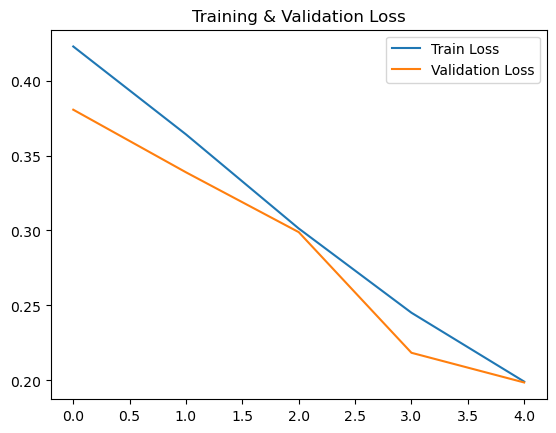

In [15]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.savefig(os.path.join(RESULT_DIR, "loss_curve.png"))
plt.show()


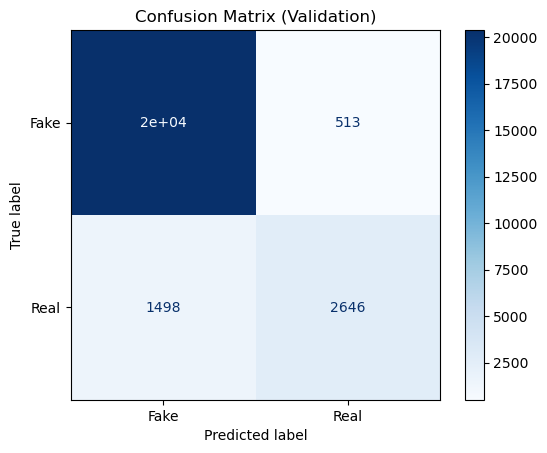

In [16]:
cm = confusion_matrix(y_tv, y_pv)
disp = ConfusionMatrixDisplay(cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.savefig(os.path.join(RESULT_DIR, "confusion_matrix.png"))
plt.show()
